<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[04:10:04] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


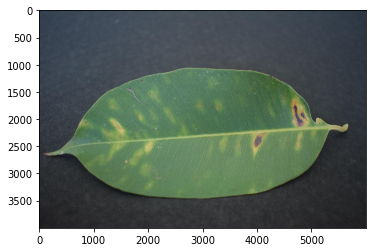

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

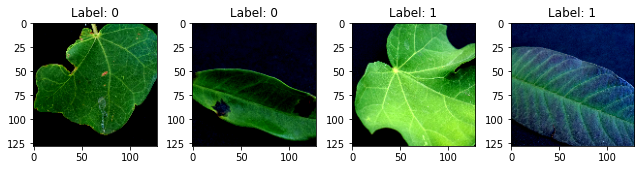

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[04:10:12] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[04:10:14] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2565987813463133 samples/sec                   batch loss = 0.9109353423118591 | accuracy = 0.65


Epoch[1] Batch[10] Speed: 1.2626872773231825 samples/sec                   batch loss = 0.6908240914344788 | accuracy = 0.625


Epoch[1] Batch[15] Speed: 1.2639101971612747 samples/sec                   batch loss = 1.2646510601043701 | accuracy = 0.6


Epoch[1] Batch[20] Speed: 1.262699441588014 samples/sec                   batch loss = 1.4436627626419067 | accuracy = 0.625


Epoch[1] Batch[25] Speed: 1.262768820391004 samples/sec                   batch loss = 1.4055477380752563 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.2638397408261686 samples/sec                   batch loss = 0.5183899402618408 | accuracy = 0.6


Epoch[1] Batch[35] Speed: 1.2633827271440952 samples/sec                   batch loss = 0.6114554405212402 | accuracy = 0.5857142857142857


Epoch[1] Batch[40] Speed: 1.2708254146055251 samples/sec                   batch loss = 0.3936516046524048 | accuracy = 0.6


Epoch[1] Batch[45] Speed: 1.2710093966514178 samples/sec                   batch loss = 0.6394869685173035 | accuracy = 0.5944444444444444


Epoch[1] Batch[50] Speed: 1.2691661133001177 samples/sec                   batch loss = 0.46208786964416504 | accuracy = 0.61


Epoch[1] Batch[55] Speed: 1.2731169009347656 samples/sec                   batch loss = 0.4390568137168884 | accuracy = 0.6090909090909091


Epoch[1] Batch[60] Speed: 1.267133479165979 samples/sec                   batch loss = 0.5020231008529663 | accuracy = 0.6125


Epoch[1] Batch[65] Speed: 1.2778502960945979 samples/sec                   batch loss = 0.4982137680053711 | accuracy = 0.6153846153846154


Epoch[1] Batch[70] Speed: 1.2700795384924835 samples/sec                   batch loss = 0.714346170425415 | accuracy = 0.6035714285714285


Epoch[1] Batch[75] Speed: 1.269778473168754 samples/sec                   batch loss = 0.356664776802063 | accuracy = 0.6066666666666667


Epoch[1] Batch[80] Speed: 1.2736844406762367 samples/sec                   batch loss = 0.6598538756370544 | accuracy = 0.609375


Epoch[1] Batch[85] Speed: 1.2716261393004273 samples/sec                   batch loss = 1.0408564805984497 | accuracy = 0.6029411764705882


Epoch[1] Batch[90] Speed: 1.2719100496657916 samples/sec                   batch loss = 0.7273105382919312 | accuracy = 0.6083333333333333


Epoch[1] Batch[95] Speed: 1.266160259396121 samples/sec                   batch loss = 0.38739314675331116 | accuracy = 0.6236842105263158


Epoch[1] Batch[100] Speed: 1.2764279649540318 samples/sec                   batch loss = 0.682976245880127 | accuracy = 0.625


Epoch[1] Batch[105] Speed: 1.2687273067709404 samples/sec                   batch loss = 0.5775038003921509 | accuracy = 0.611904761904762


Epoch[1] Batch[110] Speed: 1.2748810033929772 samples/sec                   batch loss = 1.2510912418365479 | accuracy = 0.615909090909091


Epoch[1] Batch[115] Speed: 1.2675815268369552 samples/sec                   batch loss = 0.5637916922569275 | accuracy = 0.6239130434782608


Epoch[1] Batch[120] Speed: 1.2735284908194708 samples/sec                   batch loss = 0.8054027557373047 | accuracy = 0.6270833333333333


Epoch[1] Batch[125] Speed: 1.2693394352439054 samples/sec                   batch loss = 0.7083441615104675 | accuracy = 0.628


Epoch[1] Batch[130] Speed: 1.2663231075744121 samples/sec                   batch loss = 0.2767159044742584 | accuracy = 0.6288461538461538


Epoch[1] Batch[135] Speed: 1.2701123259343197 samples/sec                   batch loss = 0.6457985639572144 | accuracy = 0.6296296296296297


Epoch[1] Batch[140] Speed: 1.2704804114010537 samples/sec                   batch loss = 0.606514573097229 | accuracy = 0.6232142857142857


Epoch[1] Batch[145] Speed: 1.267428408252192 samples/sec                   batch loss = 0.8285570740699768 | accuracy = 0.6224137931034482


Epoch[1] Batch[150] Speed: 1.2629186285739922 samples/sec                   batch loss = 0.4193435311317444 | accuracy = 0.6266666666666667


Epoch[1] Batch[155] Speed: 1.2701485767773617 samples/sec                   batch loss = 0.3592337667942047 | accuracy = 0.6338709677419355


Epoch[1] Batch[160] Speed: 1.273752227443347 samples/sec                   batch loss = 0.5174442529678345 | accuracy = 0.634375


Epoch[1] Batch[165] Speed: 1.2724133017012593 samples/sec                   batch loss = 0.4825916588306427 | accuracy = 0.6348484848484849


Epoch[1] Batch[170] Speed: 1.2709243789655746 samples/sec                   batch loss = 0.6409899592399597 | accuracy = 0.638235294117647


Epoch[1] Batch[175] Speed: 1.2709784885664166 samples/sec                   batch loss = 0.3979605436325073 | accuracy = 0.6414285714285715


Epoch[1] Batch[180] Speed: 1.266280480119192 samples/sec                   batch loss = 0.628542959690094 | accuracy = 0.6458333333333334


Epoch[1] Batch[185] Speed: 1.26602802385659 samples/sec                   batch loss = 0.38462311029434204 | accuracy = 0.6459459459459459


Epoch[1] Batch[190] Speed: 1.2696764202018607 samples/sec                   batch loss = 0.5658266544342041 | accuracy = 0.6473684210526316


Epoch[1] Batch[195] Speed: 1.2717729470686379 samples/sec                   batch loss = 0.4518149495124817 | accuracy = 0.6461538461538462


Epoch[1] Batch[200] Speed: 1.2695124202828805 samples/sec                   batch loss = 0.21618340909481049 | accuracy = 0.6425


Epoch[1] Batch[205] Speed: 1.2678057653172647 samples/sec                   batch loss = 0.4467601478099823 | accuracy = 0.6451219512195122


Epoch[1] Batch[210] Speed: 1.2758666134637824 samples/sec                   batch loss = 0.7682387828826904 | accuracy = 0.6440476190476191


Epoch[1] Batch[215] Speed: 1.271604935464436 samples/sec                   batch loss = 1.2913784980773926 | accuracy = 0.6430232558139535


Epoch[1] Batch[220] Speed: 1.2712662518731177 samples/sec                   batch loss = 0.5160461664199829 | accuracy = 0.6431818181818182


Epoch[1] Batch[225] Speed: 1.2692077830629023 samples/sec                   batch loss = 0.5829656720161438 | accuracy = 0.6433333333333333


Epoch[1] Batch[230] Speed: 1.2711578919613804 samples/sec                   batch loss = 0.6501021981239319 | accuracy = 0.6423913043478261


Epoch[1] Batch[235] Speed: 1.2707458114668317 samples/sec                   batch loss = 0.28501757979393005 | accuracy = 0.6457446808510638


Epoch[1] Batch[240] Speed: 1.2703215900705245 samples/sec                   batch loss = 0.4852137863636017 | accuracy = 0.6458333333333334


Epoch[1] Batch[245] Speed: 1.2682089426892895 samples/sec                   batch loss = 0.484690397977829 | accuracy = 0.6489795918367347


Epoch[1] Batch[250] Speed: 1.2678085436515514 samples/sec                   batch loss = 0.5230230093002319 | accuracy = 0.65


Epoch[1] Batch[255] Speed: 1.2696607581571455 samples/sec                   batch loss = 0.3189711272716522 | accuracy = 0.6529411764705882


Epoch[1] Batch[260] Speed: 1.2697143758393954 samples/sec                   batch loss = 1.170094609260559 | accuracy = 0.6519230769230769


Epoch[1] Batch[265] Speed: 1.2694822573656943 samples/sec                   batch loss = 0.39962238073349 | accuracy = 0.6509433962264151


Epoch[1] Batch[270] Speed: 1.26466094942047 samples/sec                   batch loss = 0.48206570744514465 | accuracy = 0.6527777777777778


Epoch[1] Batch[275] Speed: 1.2701837718831706 samples/sec                   batch loss = 0.5543614029884338 | accuracy = 0.6545454545454545


Epoch[1] Batch[280] Speed: 1.2655555839686488 samples/sec                   batch loss = 0.7934165000915527 | accuracy = 0.6526785714285714


Epoch[1] Batch[285] Speed: 1.26922775479474 samples/sec                   batch loss = 0.2953770160675049 | accuracy = 0.6526315789473685


Epoch[1] Batch[290] Speed: 1.2669244986303543 samples/sec                   batch loss = 0.5496312975883484 | accuracy = 0.6560344827586206


Epoch[1] Batch[295] Speed: 1.2682226515845587 samples/sec                   batch loss = 0.4475232660770416 | accuracy = 0.6584745762711864


Epoch[1] Batch[300] Speed: 1.263346766338526 samples/sec                   batch loss = 0.7151055932044983 | accuracy = 0.6558333333333334


Epoch[1] Batch[305] Speed: 1.2672293806714243 samples/sec                   batch loss = 0.5281859636306763 | accuracy = 0.6508196721311476


Epoch[1] Batch[310] Speed: 1.2703013915364203 samples/sec                   batch loss = 0.6141268610954285 | accuracy = 0.6532258064516129


Epoch[1] Batch[315] Speed: 1.2675694598646075 samples/sec                   batch loss = 0.4005615711212158 | accuracy = 0.6515873015873016


Epoch[1] Batch[320] Speed: 1.2668073121559684 samples/sec                   batch loss = 0.6411856412887573 | accuracy = 0.6515625


Epoch[1] Batch[325] Speed: 1.2629497163236314 samples/sec                   batch loss = 0.6044588685035706 | accuracy = 0.6515384615384615


Epoch[1] Batch[330] Speed: 1.2648206468663505 samples/sec                   batch loss = 0.8237946629524231 | accuracy = 0.6537878787878788


Epoch[1] Batch[335] Speed: 1.2685425460229205 samples/sec                   batch loss = 0.2745056450366974 | accuracy = 0.6574626865671642


Epoch[1] Batch[340] Speed: 1.2691333746916564 samples/sec                   batch loss = 1.1459323167800903 | accuracy = 0.6566176470588235


Epoch[1] Batch[345] Speed: 1.269766748735869 samples/sec                   batch loss = 0.5208960175514221 | accuracy = 0.6579710144927536


Epoch[1] Batch[350] Speed: 1.2710378026034084 samples/sec                   batch loss = 0.4134540259838104 | accuracy = 0.6585714285714286


Epoch[1] Batch[355] Speed: 1.2690163551765927 samples/sec                   batch loss = 0.2936275601387024 | accuracy = 0.6598591549295775


Epoch[1] Batch[360] Speed: 1.2702305093826027 samples/sec                   batch loss = 0.3884664475917816 | accuracy = 0.6611111111111111


Epoch[1] Batch[365] Speed: 1.2710540764157539 samples/sec                   batch loss = 1.0857875347137451 | accuracy = 0.6636986301369863


Epoch[1] Batch[370] Speed: 1.2708743172462023 samples/sec                   batch loss = 0.542822539806366 | accuracy = 0.6621621621621622


Epoch[1] Batch[375] Speed: 1.2711173460241898 samples/sec                   batch loss = 0.7973592281341553 | accuracy = 0.6593333333333333


Epoch[1] Batch[380] Speed: 1.2721527995304234 samples/sec                   batch loss = 0.7536056041717529 | accuracy = 0.6592105263157895


Epoch[1] Batch[385] Speed: 1.2638330764443817 samples/sec                   batch loss = 0.6636792421340942 | accuracy = 0.6577922077922078


Epoch[1] Batch[390] Speed: 1.2693839016319965 samples/sec                   batch loss = 0.3591954708099365 | accuracy = 0.6583333333333333


Epoch[1] Batch[395] Speed: 1.2660305077956804 samples/sec                   batch loss = 0.2103230208158493 | accuracy = 0.660759493670886


Epoch[1] Batch[400] Speed: 1.2709822436740905 samples/sec                   batch loss = 0.4969068765640259 | accuracy = 0.66125


Epoch[1] Batch[405] Speed: 1.276441269431394 samples/sec                   batch loss = 0.2583024799823761 | accuracy = 0.6635802469135802


Epoch[1] Batch[410] Speed: 1.2746174563439454 samples/sec                   batch loss = 1.2910478115081787 | accuracy = 0.6621951219512195


Epoch[1] Batch[415] Speed: 1.2643664491791446 samples/sec                   batch loss = 0.18505644798278809 | accuracy = 0.6644578313253012


Epoch[1] Batch[420] Speed: 1.267483082374612 samples/sec                   batch loss = 0.6291795372962952 | accuracy = 0.6660714285714285


Epoch[1] Batch[425] Speed: 1.260054110204234 samples/sec                   batch loss = 0.5854370594024658 | accuracy = 0.6658823529411765


Epoch[1] Batch[430] Speed: 1.2596595051374555 samples/sec                   batch loss = 1.0012208223342896 | accuracy = 0.6645348837209303


Epoch[1] Batch[435] Speed: 1.2702979289950684 samples/sec                   batch loss = 0.4376879930496216 | accuracy = 0.664367816091954


Epoch[1] Batch[440] Speed: 1.2699034190973242 samples/sec                   batch loss = 0.46124839782714844 | accuracy = 0.6636363636363637


Epoch[1] Batch[445] Speed: 1.2704008514764007 samples/sec                   batch loss = 0.34797629714012146 | accuracy = 0.6640449438202247


Epoch[1] Batch[450] Speed: 1.2687269229960656 samples/sec                   batch loss = 0.5487104654312134 | accuracy = 0.6644444444444444


Epoch[1] Batch[455] Speed: 1.2672622125658644 samples/sec                   batch loss = 0.24580170214176178 | accuracy = 0.6653846153846154


Epoch[1] Batch[460] Speed: 1.2714281037390736 samples/sec                   batch loss = 0.2225346565246582 | accuracy = 0.6657608695652174


Epoch[1] Batch[465] Speed: 1.268628108692437 samples/sec                   batch loss = 0.4955480694770813 | accuracy = 0.6661290322580645


Epoch[1] Batch[470] Speed: 1.273432696794698 samples/sec                   batch loss = 0.3992573618888855 | accuracy = 0.6675531914893617


Epoch[1] Batch[475] Speed: 1.2699022656378498 samples/sec                   batch loss = 0.5763099789619446 | accuracy = 0.6678947368421052


Epoch[1] Batch[480] Speed: 1.2680909434060952 samples/sec                   batch loss = 0.7544201016426086 | accuracy = 0.6692708333333334


Epoch[1] Batch[485] Speed: 1.2784019975031211 samples/sec                   batch loss = 0.5730818510055542 | accuracy = 0.6711340206185566


Epoch[1] Batch[490] Speed: 1.2735955842169704 samples/sec                   batch loss = 0.9175865054130554 | accuracy = 0.6709183673469388


Epoch[1] Batch[495] Speed: 1.272785715548307 samples/sec                   batch loss = 0.7154218554496765 | accuracy = 0.6712121212121213


Epoch[1] Batch[500] Speed: 1.2670485007415124 samples/sec                   batch loss = 0.3790588080883026 | accuracy = 0.67


Epoch[1] Batch[505] Speed: 1.2717739111187252 samples/sec                   batch loss = 0.48213717341423035 | accuracy = 0.6707920792079208


Epoch[1] Batch[510] Speed: 1.27009328785877 samples/sec                   batch loss = 0.38435423374176025 | accuracy = 0.6705882352941176


Epoch[1] Batch[515] Speed: 1.2730564267009847 samples/sec                   batch loss = 0.6280562877655029 | accuracy = 0.670388349514563


Epoch[1] Batch[520] Speed: 1.2674913174147378 samples/sec                   batch loss = 0.683229386806488 | accuracy = 0.6706730769230769


Epoch[1] Batch[525] Speed: 1.2675074047785706 samples/sec                   batch loss = 0.520650327205658 | accuracy = 0.6719047619047619


Epoch[1] Batch[530] Speed: 1.2686955501853487 samples/sec                   batch loss = 0.09839844703674316 | accuracy = 0.6740566037735849


Epoch[1] Batch[535] Speed: 1.2720623241099072 samples/sec                   batch loss = 0.5009864568710327 | accuracy = 0.6742990654205607


Epoch[1] Batch[540] Speed: 1.2706298416720325 samples/sec                   batch loss = 0.6553171873092651 | accuracy = 0.675


Epoch[1] Batch[545] Speed: 1.2609996696654828 samples/sec                   batch loss = 0.4846843481063843 | accuracy = 0.6770642201834862


Epoch[1] Batch[550] Speed: 1.2647625790692592 samples/sec                   batch loss = 0.40253010392189026 | accuracy = 0.6777272727272727


Epoch[1] Batch[555] Speed: 1.2656482869270784 samples/sec                   batch loss = 0.4398270845413208 | accuracy = 0.6779279279279279


Epoch[1] Batch[560] Speed: 1.266996064788226 samples/sec                   batch loss = 0.5179132223129272 | accuracy = 0.678125


Epoch[1] Batch[565] Speed: 1.2664111433083862 samples/sec                   batch loss = 0.26160916686058044 | accuracy = 0.679646017699115


Epoch[1] Batch[570] Speed: 1.2672781983897459 samples/sec                   batch loss = 0.439248263835907 | accuracy = 0.6815789473684211


Epoch[1] Batch[575] Speed: 1.265350177400912 samples/sec                   batch loss = 0.436105340719223 | accuracy = 0.6808695652173913


Epoch[1] Batch[580] Speed: 1.2611200499119588 samples/sec                   batch loss = 1.896119475364685 | accuracy = 0.6797413793103448


Epoch[1] Batch[585] Speed: 1.2661183117502826 samples/sec                   batch loss = 0.18868298828601837 | accuracy = 0.6807692307692308


Epoch[1] Batch[590] Speed: 1.2655280907487445 samples/sec                   batch loss = 0.8485497236251831 | accuracy = 0.6809322033898305


Epoch[1] Batch[595] Speed: 1.2683934144791251 samples/sec                   batch loss = 0.22752249240875244 | accuracy = 0.6823529411764706


Epoch[1] Batch[600] Speed: 1.2719543106125961 samples/sec                   batch loss = 0.9163600206375122 | accuracy = 0.6816666666666666


Epoch[1] Batch[605] Speed: 1.2660705387737317 samples/sec                   batch loss = 0.8164377212524414 | accuracy = 0.6805785123966942


Epoch[1] Batch[610] Speed: 1.2733814707886544 samples/sec                   batch loss = 0.21060824394226074 | accuracy = 0.6815573770491803


Epoch[1] Batch[615] Speed: 1.2754635954367013 samples/sec                   batch loss = 0.5495731830596924 | accuracy = 0.682520325203252


Epoch[1] Batch[620] Speed: 1.2665372440347369 samples/sec                   batch loss = 0.8152514696121216 | accuracy = 0.6818548387096774


Epoch[1] Batch[625] Speed: 1.2669234462471775 samples/sec                   batch loss = 0.3294074535369873 | accuracy = 0.6832


Epoch[1] Batch[630] Speed: 1.2681167269147262 samples/sec                   batch loss = 0.45984864234924316 | accuracy = 0.6825396825396826


Epoch[1] Batch[635] Speed: 1.268998885697628 samples/sec                   batch loss = 0.4364638030529022 | accuracy = 0.681496062992126


Epoch[1] Batch[640] Speed: 1.2657231465998906 samples/sec                   batch loss = 0.5232630968093872 | accuracy = 0.681640625


Epoch[1] Batch[645] Speed: 1.2661535705191744 samples/sec                   batch loss = 0.46028026938438416 | accuracy = 0.681782945736434


Epoch[1] Batch[650] Speed: 1.2779324466351818 samples/sec                   batch loss = 0.6842097043991089 | accuracy = 0.683076923076923


Epoch[1] Batch[655] Speed: 1.2681246826327734 samples/sec                   batch loss = 0.3599981367588043 | accuracy = 0.683969465648855


Epoch[1] Batch[660] Speed: 1.2640013259901606 samples/sec                   batch loss = 0.8147957921028137 | accuracy = 0.6833333333333333


Epoch[1] Batch[665] Speed: 1.2675075962972664 samples/sec                   batch loss = 0.5075890421867371 | accuracy = 0.6838345864661655


Epoch[1] Batch[670] Speed: 1.266385620288479 samples/sec                   batch loss = 0.3009571433067322 | accuracy = 0.6828358208955224


Epoch[1] Batch[675] Speed: 1.2692507998817388 samples/sec                   batch loss = 0.4700204133987427 | accuracy = 0.6840740740740741


Epoch[1] Batch[680] Speed: 1.2652163935605636 samples/sec                   batch loss = 0.4209305942058563 | accuracy = 0.6849264705882353


Epoch[1] Batch[685] Speed: 1.2637294067560936 samples/sec                   batch loss = 0.9396756887435913 | accuracy = 0.6835766423357664


Epoch[1] Batch[690] Speed: 1.2673575591386883 samples/sec                   batch loss = 0.7034767866134644 | accuracy = 0.6826086956521739


Epoch[1] Batch[695] Speed: 1.2681864147288844 samples/sec                   batch loss = 0.29486724734306335 | accuracy = 0.6834532374100719


Epoch[1] Batch[700] Speed: 1.2792861405310179 samples/sec                   batch loss = 0.6940686106681824 | accuracy = 0.6835714285714286


Epoch[1] Batch[705] Speed: 1.2743142360570459 samples/sec                   batch loss = 0.601746678352356 | accuracy = 0.6843971631205674


Epoch[1] Batch[710] Speed: 1.2715834432068744 samples/sec                   batch loss = 0.2477095127105713 | accuracy = 0.6845070422535211


Epoch[1] Batch[715] Speed: 1.2723171929268964 samples/sec                   batch loss = 0.1798553168773651 | accuracy = 0.686013986013986


Epoch[1] Batch[720] Speed: 1.273864415404594 samples/sec                   batch loss = 0.35543903708457947 | accuracy = 0.6871527777777777


Epoch[1] Batch[725] Speed: 1.2702651319701181 samples/sec                   batch loss = 0.4787653982639313 | accuracy = 0.6868965517241379


Epoch[1] Batch[730] Speed: 1.269437591984237 samples/sec                   batch loss = 0.2884700298309326 | accuracy = 0.6876712328767123


Epoch[1] Batch[735] Speed: 1.271827611016643 samples/sec                   batch loss = 0.4838648736476898 | accuracy = 0.6887755102040817


Epoch[1] Batch[740] Speed: 1.270998419776199 samples/sec                   batch loss = 0.21361534297466278 | accuracy = 0.6885135135135135


Epoch[1] Batch[745] Speed: 1.2656761673009678 samples/sec                   batch loss = 0.31254687905311584 | accuracy = 0.6895973154362416


Epoch[1] Batch[750] Speed: 1.2661826198692039 samples/sec                   batch loss = 0.42982417345046997 | accuracy = 0.6896666666666667


Epoch[1] Batch[755] Speed: 1.2706416782826981 samples/sec                   batch loss = 0.6208701729774475 | accuracy = 0.6880794701986755


Epoch[1] Batch[760] Speed: 1.2712875407468667 samples/sec                   batch loss = 0.5916550159454346 | accuracy = 0.6884868421052631


Epoch[1] Batch[765] Speed: 1.265849587889287 samples/sec                   batch loss = 0.4481152296066284 | accuracy = 0.6892156862745098


Epoch[1] Batch[770] Speed: 1.270281963076361 samples/sec                   batch loss = 0.8257972002029419 | accuracy = 0.6886363636363636


Epoch[1] Batch[775] Speed: 1.2573305051942436 samples/sec                   batch loss = 0.2769383490085602 | accuracy = 0.6890322580645162


Epoch[1] Batch[780] Speed: 1.265413166749772 samples/sec                   batch loss = 0.37285667657852173 | accuracy = 0.6907051282051282


Epoch[1] Batch[785] Speed: 1.260082123219679 samples/sec                   batch loss = 0.5482804775238037 | accuracy = 0.6904458598726114


[Epoch 1] training: accuracy=0.6906725888324873
[Epoch 1] time cost: 648.8891434669495
[Epoch 1] validation: validation accuracy=0.6955555555555556


Epoch[2] Batch[5] Speed: 1.2665046409093774 samples/sec                   batch loss = 0.6803464889526367 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2684202651589467 samples/sec                   batch loss = 1.2970365285873413 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.2731459808466732 samples/sec                   batch loss = 0.30655500292778015 | accuracy = 0.8


Epoch[2] Batch[20] Speed: 1.2665752990723476 samples/sec                   batch loss = 0.5118601322174072 | accuracy = 0.7875


Epoch[2] Batch[25] Speed: 1.268134267967826 samples/sec                   batch loss = 0.19524075090885162 | accuracy = 0.77


Epoch[2] Batch[30] Speed: 1.2675370908671943 samples/sec                   batch loss = 0.1350622922182083 | accuracy = 0.7916666666666666


Epoch[2] Batch[35] Speed: 1.2707454264698386 samples/sec                   batch loss = 0.43912065029144287 | accuracy = 0.8


Epoch[2] Batch[40] Speed: 1.2716372234052213 samples/sec                   batch loss = 0.41307586431503296 | accuracy = 0.79375


Epoch[2] Batch[45] Speed: 1.273901461114349 samples/sec                   batch loss = 0.28004029393196106 | accuracy = 0.7944444444444444


Epoch[2] Batch[50] Speed: 1.2698007694089808 samples/sec                   batch loss = 0.20922045409679413 | accuracy = 0.785


Epoch[2] Batch[55] Speed: 1.2689810327710114 samples/sec                   batch loss = 0.17712070047855377 | accuracy = 0.7909090909090909


Epoch[2] Batch[60] Speed: 1.2737908140038807 samples/sec                   batch loss = 1.1475636959075928 | accuracy = 0.7916666666666666


Epoch[2] Batch[65] Speed: 1.2736546593281457 samples/sec                   batch loss = 0.3354974091053009 | accuracy = 0.8


Epoch[2] Batch[70] Speed: 1.2644816596370019 samples/sec                   batch loss = 0.2720806300640106 | accuracy = 0.8


Epoch[2] Batch[75] Speed: 1.2633810146783602 samples/sec                   batch loss = 0.3180396556854248 | accuracy = 0.7933333333333333


Epoch[2] Batch[80] Speed: 1.2712198234090257 samples/sec                   batch loss = 0.762965202331543 | accuracy = 0.7875


Epoch[2] Batch[85] Speed: 1.2720945388290164 samples/sec                   batch loss = 0.34850209951400757 | accuracy = 0.7823529411764706


Epoch[2] Batch[90] Speed: 1.2665503431237515 samples/sec                   batch loss = 0.4430137574672699 | accuracy = 0.7805555555555556


Epoch[2] Batch[95] Speed: 1.271642910107896 samples/sec                   batch loss = 0.6520377993583679 | accuracy = 0.781578947368421


Epoch[2] Batch[100] Speed: 1.2695123242203594 samples/sec                   batch loss = 1.0356310606002808 | accuracy = 0.775


Epoch[2] Batch[105] Speed: 1.2715787207902376 samples/sec                   batch loss = 0.3942454159259796 | accuracy = 0.780952380952381


Epoch[2] Batch[110] Speed: 1.27178220200981 samples/sec                   batch loss = 0.6438249349594116 | accuracy = 0.7772727272727272


Epoch[2] Batch[115] Speed: 1.272618884262048 samples/sec                   batch loss = 0.08447612076997757 | accuracy = 0.7782608695652173


Epoch[2] Batch[120] Speed: 1.275416762927958 samples/sec                   batch loss = 0.22599095106124878 | accuracy = 0.7791666666666667


Epoch[2] Batch[125] Speed: 1.2726093275441999 samples/sec                   batch loss = 0.11338314414024353 | accuracy = 0.786


Epoch[2] Batch[130] Speed: 1.270765735379641 samples/sec                   batch loss = 0.16293033957481384 | accuracy = 0.7865384615384615


Epoch[2] Batch[135] Speed: 1.2770313152941122 samples/sec                   batch loss = 0.8229381442070007 | accuracy = 0.7833333333333333


Epoch[2] Batch[140] Speed: 1.2718794834463343 samples/sec                   batch loss = 0.5985695719718933 | accuracy = 0.7803571428571429


Epoch[2] Batch[145] Speed: 1.2671673588779162 samples/sec                   batch loss = 0.24974755942821503 | accuracy = 0.7844827586206896


Epoch[2] Batch[150] Speed: 1.266730985198533 samples/sec                   batch loss = 0.5084711909294128 | accuracy = 0.7816666666666666


Epoch[2] Batch[155] Speed: 1.2652163935605636 samples/sec                   batch loss = 0.7491709589958191 | accuracy = 0.7806451612903226


Epoch[2] Batch[160] Speed: 1.2782386575017441 samples/sec                   batch loss = 0.46523648500442505 | accuracy = 0.7796875


Epoch[2] Batch[165] Speed: 1.2695991706734162 samples/sec                   batch loss = 0.5373111367225647 | accuracy = 0.7787878787878788


Epoch[2] Batch[170] Speed: 1.2677199303681093 samples/sec                   batch loss = 0.4252842664718628 | accuracy = 0.7794117647058824


Epoch[2] Batch[175] Speed: 1.2698048058810043 samples/sec                   batch loss = 0.1812809705734253 | accuracy = 0.7814285714285715


Epoch[2] Batch[180] Speed: 1.265885691322234 samples/sec                   batch loss = 0.1949610412120819 | accuracy = 0.7847222222222222


Epoch[2] Batch[185] Speed: 1.2645176850813404 samples/sec                   batch loss = 0.5016480088233948 | accuracy = 0.7810810810810811


Epoch[2] Batch[190] Speed: 1.2691233902322254 samples/sec                   batch loss = 0.3916344940662384 | accuracy = 0.7776315789473685


Epoch[2] Batch[195] Speed: 1.2726453349163886 samples/sec                   batch loss = 0.24885791540145874 | accuracy = 0.7717948717948718


Epoch[2] Batch[200] Speed: 1.2714435203519285 samples/sec                   batch loss = 1.6505937576293945 | accuracy = 0.7675


Epoch[2] Batch[205] Speed: 1.2678352737656164 samples/sec                   batch loss = 0.6112357378005981 | accuracy = 0.7634146341463415


Epoch[2] Batch[210] Speed: 1.2613977704290125 samples/sec                   batch loss = 0.8859846591949463 | accuracy = 0.7619047619047619


Epoch[2] Batch[215] Speed: 1.267213108934436 samples/sec                   batch loss = 0.37673261761665344 | accuracy = 0.7616279069767442


Epoch[2] Batch[220] Speed: 1.2659146328626967 samples/sec                   batch loss = 0.6306918263435364 | accuracy = 0.7625


Epoch[2] Batch[225] Speed: 1.2700306969969237 samples/sec                   batch loss = 0.4243899881839752 | accuracy = 0.7611111111111111


Epoch[2] Batch[230] Speed: 1.2686898898128622 samples/sec                   batch loss = 0.5341274738311768 | accuracy = 0.7597826086956522


Epoch[2] Batch[235] Speed: 1.2701851181827797 samples/sec                   batch loss = 0.6320425271987915 | accuracy = 0.7595744680851064


Epoch[2] Batch[240] Speed: 1.2674221847019118 samples/sec                   batch loss = 0.7427247762680054 | accuracy = 0.7604166666666666


Epoch[2] Batch[245] Speed: 1.2689138488398706 samples/sec                   batch loss = 0.40982845425605774 | accuracy = 0.7581632653061224


Epoch[2] Batch[250] Speed: 1.2708865434944467 samples/sec                   batch loss = 0.5031073689460754 | accuracy = 0.759


Epoch[2] Batch[255] Speed: 1.2719202708745152 samples/sec                   batch loss = 0.5815376043319702 | accuracy = 0.7598039215686274


Epoch[2] Batch[260] Speed: 1.2664880053572727 samples/sec                   batch loss = 0.500318169593811 | accuracy = 0.7567307692307692


Epoch[2] Batch[265] Speed: 1.2698784279445046 samples/sec                   batch loss = 0.5235815644264221 | accuracy = 0.7556603773584906


Epoch[2] Batch[270] Speed: 1.264819884036425 samples/sec                   batch loss = 0.098607636988163 | accuracy = 0.7583333333333333


Epoch[2] Batch[275] Speed: 1.2663885835825708 samples/sec                   batch loss = 0.220622718334198 | accuracy = 0.7572727272727273


Epoch[2] Batch[280] Speed: 1.273524237297695 samples/sec                   batch loss = 0.244920551776886 | accuracy = 0.7580357142857143


Epoch[2] Batch[285] Speed: 1.2709358359520748 samples/sec                   batch loss = 0.31008654832839966 | accuracy = 0.7587719298245614


Epoch[2] Batch[290] Speed: 1.2689058832169333 samples/sec                   batch loss = 0.8137014508247375 | accuracy = 0.7586206896551724


Epoch[2] Batch[295] Speed: 1.2694866760473944 samples/sec                   batch loss = 0.2497130036354065 | accuracy = 0.7593220338983051


Epoch[2] Batch[300] Speed: 1.2716166938679638 samples/sec                   batch loss = 0.4460015892982483 | accuracy = 0.7591666666666667


Epoch[2] Batch[305] Speed: 1.2737168343081768 samples/sec                   batch loss = 0.46454918384552 | accuracy = 0.7565573770491804


Epoch[2] Batch[310] Speed: 1.2703429435050322 samples/sec                   batch loss = 0.42016103863716125 | accuracy = 0.7556451612903226


Epoch[2] Batch[315] Speed: 1.2707750719209134 samples/sec                   batch loss = 0.331569105386734 | accuracy = 0.7515873015873016


Epoch[2] Batch[320] Speed: 1.268546094917662 samples/sec                   batch loss = 0.5455353260040283 | accuracy = 0.75


Epoch[2] Batch[325] Speed: 1.271405557615975 samples/sec                   batch loss = 0.7684128880500793 | accuracy = 0.75


Epoch[2] Batch[330] Speed: 1.2710237439057632 samples/sec                   batch loss = 0.3472888171672821 | accuracy = 0.75


Epoch[2] Batch[335] Speed: 1.2702917734126062 samples/sec                   batch loss = 0.4341526925563812 | accuracy = 0.7485074626865672


Epoch[2] Batch[340] Speed: 1.2731179636324121 samples/sec                   batch loss = 0.08404597640037537 | accuracy = 0.75


Epoch[2] Batch[345] Speed: 1.2690781741182793 samples/sec                   batch loss = 0.4308531880378723 | accuracy = 0.7492753623188406


Epoch[2] Batch[350] Speed: 1.2681119343616722 samples/sec                   batch loss = 0.27228227257728577 | accuracy = 0.7507142857142857


Epoch[2] Batch[355] Speed: 1.2739034924035646 samples/sec                   batch loss = 0.2945437729358673 | accuracy = 0.7528169014084507


Epoch[2] Batch[360] Speed: 1.2666993284700014 samples/sec                   batch loss = 0.5270327925682068 | accuracy = 0.7548611111111111


Epoch[2] Batch[365] Speed: 1.270447508748649 samples/sec                   batch loss = 1.5774518251419067 | accuracy = 0.7506849315068493


Epoch[2] Batch[370] Speed: 1.27523489536512 samples/sec                   batch loss = 0.11881838738918304 | accuracy = 0.7506756756756757


Epoch[2] Batch[375] Speed: 1.2702631122673416 samples/sec                   batch loss = 1.5405837297439575 | accuracy = 0.7506666666666667


Epoch[2] Batch[380] Speed: 1.2690319053372026 samples/sec                   batch loss = 0.40567895770072937 | accuracy = 0.7506578947368421


Epoch[2] Batch[385] Speed: 1.2686012492124747 samples/sec                   batch loss = 0.6299650073051453 | accuracy = 0.7519480519480519


Epoch[2] Batch[390] Speed: 1.2688571319448463 samples/sec                   batch loss = 0.6711058020591736 | accuracy = 0.7506410256410256


Epoch[2] Batch[395] Speed: 1.2672039203734566 samples/sec                   batch loss = 0.3642183244228363 | accuracy = 0.7512658227848101


Epoch[2] Batch[400] Speed: 1.269173506122887 samples/sec                   batch loss = 0.6245745420455933 | accuracy = 0.7525


Epoch[2] Batch[405] Speed: 1.2704172051817393 samples/sec                   batch loss = 0.5009087920188904 | accuracy = 0.7524691358024691


Epoch[2] Batch[410] Speed: 1.2709697267348 samples/sec                   batch loss = 0.2923460304737091 | accuracy = 0.7530487804878049


Epoch[2] Batch[415] Speed: 1.2680204993882185 samples/sec                   batch loss = 0.3087947368621826 | accuracy = 0.7530120481927711


Epoch[2] Batch[420] Speed: 1.268347675045904 samples/sec                   batch loss = 0.5453916788101196 | accuracy = 0.7529761904761905


Epoch[2] Batch[425] Speed: 1.2725308520476848 samples/sec                   batch loss = 0.32523074746131897 | accuracy = 0.7529411764705882


Epoch[2] Batch[430] Speed: 1.2662445453012645 samples/sec                   batch loss = 0.3489037752151489 | accuracy = 0.7517441860465116


Epoch[2] Batch[435] Speed: 1.2691555522741322 samples/sec                   batch loss = 0.5072880983352661 | accuracy = 0.7505747126436781


Epoch[2] Batch[440] Speed: 1.2672914085365712 samples/sec                   batch loss = 0.23391535878181458 | accuracy = 0.7511363636363636


Epoch[2] Batch[445] Speed: 1.2694441234997285 samples/sec                   batch loss = 0.8323427438735962 | accuracy = 0.7522471910112359


Epoch[2] Batch[450] Speed: 1.2735782784710576 samples/sec                   batch loss = 0.4322686791419983 | accuracy = 0.7538888888888889


Epoch[2] Batch[455] Speed: 1.2712236762645583 samples/sec                   batch loss = 0.5058857798576355 | accuracy = 0.7543956043956044


Epoch[2] Batch[460] Speed: 1.2713329144361605 samples/sec                   batch loss = 0.22433479130268097 | accuracy = 0.7548913043478261


Epoch[2] Batch[465] Speed: 1.2747465526934174 samples/sec                   batch loss = 0.3205500841140747 | accuracy = 0.7543010752688172


Epoch[2] Batch[470] Speed: 1.2752217129525574 samples/sec                   batch loss = 0.2778366208076477 | accuracy = 0.7542553191489362


Epoch[2] Batch[475] Speed: 1.269171585900901 samples/sec                   batch loss = 0.17734478414058685 | accuracy = 0.7557894736842106


Epoch[2] Batch[480] Speed: 1.2689294924627224 samples/sec                   batch loss = 0.4402877986431122 | accuracy = 0.7557291666666667


Epoch[2] Batch[485] Speed: 1.2647216773685805 samples/sec                   batch loss = 0.4163821339607239 | accuracy = 0.7541237113402062


Epoch[2] Batch[490] Speed: 1.2656153476572765 samples/sec                   batch loss = 0.22733356058597565 | accuracy = 0.7561224489795918


Epoch[2] Batch[495] Speed: 1.2734096929085723 samples/sec                   batch loss = 0.3768160045146942 | accuracy = 0.7570707070707071


Epoch[2] Batch[500] Speed: 1.2667886599825806 samples/sec                   batch loss = 0.5941600203514099 | accuracy = 0.7555


Epoch[2] Batch[505] Speed: 1.2705889445114134 samples/sec                   batch loss = 0.2772718071937561 | accuracy = 0.7564356435643564


Epoch[2] Batch[510] Speed: 1.2677606430411477 samples/sec                   batch loss = 0.35847800970077515 | accuracy = 0.7558823529411764


Epoch[2] Batch[515] Speed: 1.2711950693692908 samples/sec                   batch loss = 0.27987322211265564 | accuracy = 0.7558252427184466


Epoch[2] Batch[520] Speed: 1.274094269003805 samples/sec                   batch loss = 1.116420030593872 | accuracy = 0.7548076923076923


Epoch[2] Batch[525] Speed: 1.2726243866798592 samples/sec                   batch loss = 0.7990645170211792 | accuracy = 0.7547619047619047


Epoch[2] Batch[530] Speed: 1.2734625644247097 samples/sec                   batch loss = 0.5515261292457581 | accuracy = 0.755188679245283


Epoch[2] Batch[535] Speed: 1.2728961881054894 samples/sec                   batch loss = 0.47900158166885376 | accuracy = 0.7560747663551401


Epoch[2] Batch[540] Speed: 1.2680746495361008 samples/sec                   batch loss = 0.4878525733947754 | accuracy = 0.7578703703703704


Epoch[2] Batch[545] Speed: 1.2671129033890396 samples/sec                   batch loss = 0.3339769244194031 | accuracy = 0.7573394495412844


Epoch[2] Batch[550] Speed: 1.2769391727501325 samples/sec                   batch loss = 0.31123068928718567 | accuracy = 0.7581818181818182


Epoch[2] Batch[555] Speed: 1.2676050868260906 samples/sec                   batch loss = 0.7580760717391968 | accuracy = 0.7581081081081081


Epoch[2] Batch[560] Speed: 1.2733531532749998 samples/sec                   batch loss = 0.13333705067634583 | accuracy = 0.7589285714285714


Epoch[2] Batch[565] Speed: 1.2718693593126824 samples/sec                   batch loss = 0.42531585693359375 | accuracy = 0.7584070796460177


Epoch[2] Batch[570] Speed: 1.2688285355009146 samples/sec                   batch loss = 0.36569944024086 | accuracy = 0.7583333333333333


Epoch[2] Batch[575] Speed: 1.270377091254789 samples/sec                   batch loss = 0.7768484354019165 | accuracy = 0.758695652173913


Epoch[2] Batch[580] Speed: 1.2689172078674729 samples/sec                   batch loss = 0.9160422086715698 | accuracy = 0.7581896551724138


Epoch[2] Batch[585] Speed: 1.2717789242027397 samples/sec                   batch loss = 0.28144320845603943 | accuracy = 0.7576923076923077


Epoch[2] Batch[590] Speed: 1.272029146583834 samples/sec                   batch loss = 0.3879402279853821 | accuracy = 0.7567796610169492


Epoch[2] Batch[595] Speed: 1.27103655078895 samples/sec                   batch loss = 0.4691791534423828 | accuracy = 0.7571428571428571


Epoch[2] Batch[600] Speed: 1.2706947051559685 samples/sec                   batch loss = 0.40302684903144836 | accuracy = 0.7570833333333333


Epoch[2] Batch[605] Speed: 1.2720051325356634 samples/sec                   batch loss = 0.539791464805603 | accuracy = 0.7582644628099173


Epoch[2] Batch[610] Speed: 1.271013633390811 samples/sec                   batch loss = 0.5329758524894714 | accuracy = 0.7581967213114754


Epoch[2] Batch[615] Speed: 1.272780597966278 samples/sec                   batch loss = 0.4559907019138336 | accuracy = 0.7569105691056911


Epoch[2] Batch[620] Speed: 1.2678574060033412 samples/sec                   batch loss = 0.6393354535102844 | accuracy = 0.7560483870967742


Epoch[2] Batch[625] Speed: 1.273205110877154 samples/sec                   batch loss = 1.157397747039795 | accuracy = 0.7552


Epoch[2] Batch[630] Speed: 1.2734859568802614 samples/sec                   batch loss = 0.10976333916187286 | accuracy = 0.7559523809523809


Epoch[2] Batch[635] Speed: 1.273953212645089 samples/sec                   batch loss = 1.1135668754577637 | accuracy = 0.7559055118110236


Epoch[2] Batch[640] Speed: 1.2698082657345928 samples/sec                   batch loss = 0.30503910779953003 | accuracy = 0.755859375


Epoch[2] Batch[645] Speed: 1.270878649354498 samples/sec                   batch loss = 0.3975863456726074 | accuracy = 0.7558139534883721


Epoch[2] Batch[650] Speed: 1.2728042550579795 samples/sec                   batch loss = 1.2843338251113892 | accuracy = 0.7557692307692307


Epoch[2] Batch[655] Speed: 1.2734778370875663 samples/sec                   batch loss = 0.42773744463920593 | accuracy = 0.7564885496183206


Epoch[2] Batch[660] Speed: 1.2725136717421184 samples/sec                   batch loss = 1.0538452863693237 | accuracy = 0.756439393939394


Epoch[2] Batch[665] Speed: 1.2684932472147115 samples/sec                   batch loss = 0.5328471064567566 | accuracy = 0.7556390977443609


Epoch[2] Batch[670] Speed: 1.274831113837146 samples/sec                   batch loss = 0.16789767146110535 | accuracy = 0.755223880597015


Epoch[2] Batch[675] Speed: 1.2755813221473102 samples/sec                   batch loss = 0.3259257674217224 | accuracy = 0.7559259259259259


Epoch[2] Batch[680] Speed: 1.2736032220979954 samples/sec                   batch loss = 0.7135444283485413 | accuracy = 0.7555147058823529


Epoch[2] Batch[685] Speed: 1.269812206146366 samples/sec                   batch loss = 0.3213297128677368 | accuracy = 0.7562043795620438


Epoch[2] Batch[690] Speed: 1.2700505023474473 samples/sec                   batch loss = 0.5261452794075012 | accuracy = 0.7568840579710145


Epoch[2] Batch[695] Speed: 1.2719932705090826 samples/sec                   batch loss = 0.4012933671474457 | accuracy = 0.7579136690647482


Epoch[2] Batch[700] Speed: 1.271363550733171 samples/sec                   batch loss = 0.3289278447628021 | accuracy = 0.7582142857142857


Epoch[2] Batch[705] Speed: 1.2704985951769687 samples/sec                   batch loss = 0.38781896233558655 | accuracy = 0.7567375886524823


Epoch[2] Batch[710] Speed: 1.2684210323379315 samples/sec                   batch loss = 0.5538012385368347 | accuracy = 0.7566901408450705


Epoch[2] Batch[715] Speed: 1.2697864497509503 samples/sec                   batch loss = 0.356597900390625 | accuracy = 0.7573426573426574


Epoch[2] Batch[720] Speed: 1.2690629108072133 samples/sec                   batch loss = 0.4893309772014618 | accuracy = 0.7569444444444444


Epoch[2] Batch[725] Speed: 1.2765407219008487 samples/sec                   batch loss = 0.5478246212005615 | accuracy = 0.756896551724138


Epoch[2] Batch[730] Speed: 1.2715029741660933 samples/sec                   batch loss = 0.579032838344574 | accuracy = 0.7568493150684932


Epoch[2] Batch[735] Speed: 1.2705597888491165 samples/sec                   batch loss = 0.7721123695373535 | accuracy = 0.7568027210884354


Epoch[2] Batch[740] Speed: 1.2704986913888074 samples/sec                   batch loss = 0.32132306694984436 | accuracy = 0.7560810810810811


Epoch[2] Batch[745] Speed: 1.2690077163631435 samples/sec                   batch loss = 0.3226891756057739 | accuracy = 0.7553691275167785


Epoch[2] Batch[750] Speed: 1.2774830838655287 samples/sec                   batch loss = 0.2783021330833435 | accuracy = 0.755


Epoch[2] Batch[755] Speed: 1.2674446855188168 samples/sec                   batch loss = 0.7421204447746277 | accuracy = 0.7549668874172185


Epoch[2] Batch[760] Speed: 1.270620795955635 samples/sec                   batch loss = 0.5329769849777222 | accuracy = 0.7542763157894737


Epoch[2] Batch[765] Speed: 1.2744551787549074 samples/sec                   batch loss = 0.2647761106491089 | accuracy = 0.7545751633986928


Epoch[2] Batch[770] Speed: 1.2716625729972444 samples/sec                   batch loss = 1.514115571975708 | accuracy = 0.7535714285714286


Epoch[2] Batch[775] Speed: 1.2720144872980257 samples/sec                   batch loss = 0.3187049627304077 | accuracy = 0.7545161290322581


Epoch[2] Batch[780] Speed: 1.279610177349994 samples/sec                   batch loss = 0.4840974807739258 | accuracy = 0.7551282051282051


Epoch[2] Batch[785] Speed: 1.271919017321211 samples/sec                   batch loss = 0.7693816423416138 | accuracy = 0.7550955414012739


[Epoch 2] training: accuracy=0.7557106598984772
[Epoch 2] time cost: 638.3173539638519
[Epoch 2] validation: validation accuracy=0.7766666666666666


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7644444444444445

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)